<h1 align="center">Zewail City of Science and Technology</h1>
<h2 align="center">CIE 417 (Fall 2020)</h2>
<h2 align="center">Lab 5: Decision Trees </h2>
<h3 align="center">Eng. Ahmed Wael</h3>

## Import the needed libraries

In [ ]:
import numpy as np
from collections import Counter
from scipy import stats
from math import log2, sqrt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing
import matplotlib.pyplot as plt
import six

from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV

# Exploring the dataset

## We are going to use a very famous dataset called [Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult)


The objective of this dataset is to predict whether income exceeds 50,000 dollars per year based on census data. 
So, we will use the decision tree algorithm to predict if an individual earns more than $50K annually and is therefore eligible for the new credit card.


### Dataset attributes 

1. age : continuous variable
2. state_sample	: continuous variable
3. education_num : continuous variable
4. capital_gain : continuous variable
5. capital_loss : continuous variable
6. hours_per_week : continuous variable
7. workclass : categorical variable
8. education : categorical variable
9. marital_status : categorical variable
10. occupation : categorical variable
11. relationship	: categorical variable
12. c1	: categorical variable
13. c2	: categorical variable
14. c3 : categorical variable

### Load the dataset

In [ ]:
data = pd.read_csv("adult_data.csv")
data.head()

,age,workclass,state_sample,education,education_num,marital_status,occupation,relationship,c1,c2,capital_gain,capital_loss,hours_per_week,c3,eligible
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,c14,c21,2174,0,40,c337,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,c14,c21,0,0,13,c337,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,c14,c21,0,0,40,c337,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,c12,c21,0,0,40,c337,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,c12,c20,0,0,40,c34,0


### Describe the dataset

In [ ]:
data.describe()

,age,state_sample,education_num,capital_gain,capital_loss,hours_per_week,eligible
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238,0.248922
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984,0.432396
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [ ]:
print(f'dataset shape is {data.shape}')

dataset shape is (30162, 15)


### Which ones are categorical and which are numerical?

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   state_sample    30162 non-null  int64 
 3   education       30162 non-null  object
 4   education_num   30162 non-null  int64 
 5   marital_status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   c1              30162 non-null  object
 9   c2              30162 non-null  object
 10  capital_gain    30162 non-null  int64 
 11  capital_loss    30162 non-null  int64 
 12  hours_per_week  30162 non-null  int64 
 13  c3              30162 non-null  object
 14  eligible        30162 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.5+ MB


## Data Exploration

<AxesSubplot:xlabel='eligible', ylabel='count'>

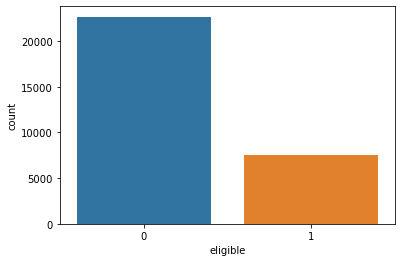

In [ ]:
## Is the dataset balanced?

sns.countplot(x='eligible',data=data)

In [ ]:

categorical = ['workclass', 'education', 'marital_status', 'occupation', 
                   'relationship', 'c1', 'c2', 'c3']
numerical = ['age', 'education_num','capital_gain', 'capital_loss',
                'hours_per_week']
 
X = pd.concat([data[categorical], data[numerical]], axis=1) ## Just sort them, no need for encoding
y = data['eligible']
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2 , random_state = 10)

# What is Entropy ?

<img src="https://i.ibb.co/x88jGKC/Entropy-Versus-Probability.png">
<br/> 
<br/> 
source: http://matlabdatamining.blogspot.com/2006/11/introduction-to-entropy.html

$$Entropy\ H(\pi) = -\sum \pi log_2(\pi)$$

## Entropy Implementation 

In [ ]:
def entropy(class_y):
    """ 
    Input: 
        - class_y: list of class labels (0's and 1's)
    
    Output: 
        - The entropy
        
    Compute the entropy for a list of classes
    """
    
    if len(class_y) <=1: ## Handling if there is only 1 or 0 labels
        return 0
    
    total_count = np.bincount(class_y) # count
    probabilities = total_count[np.nonzero(total_count)] / len(class_y) # Find the probabilities
    if len(probabilities) <= 1 : ## Handling if the length of the probabilities is less than or equal to 1
        return 0

    return - np.sum(probabilities * np.log(probabilities)) / np.log(len(probabilities) ) ## Entropy equation

# Information Gain

$$Conditional\ Entropy\ H(Y|X)= -\sum p(Y=y, X=x )\log\frac{p(Y=y, X=x )}{p(X=x)}$$

$$Information\ Gain\ IG(Y|X)= H(Y) - H(Y|X)$$

In [ ]:
def information_gain(previous_y, current_y):
    """
    Inputs:
        - previous_y : the distribution of original labels (0's and 1's)
        - current_y  : the distribution of labels after splitting based on a particular
                     split attribute and split value
    
    Outputs:
        - info_gain : The information gain after partitioning
        
    Compute and return the information gain from partitioning the previous_y labels into the current_y labels.
    
    """ 
    conditional_entropy = 0 ## IG = H(Y) - CE(Y|X)
    for y in current_y:
        conditional_entropy += (entropy(y)*len(y)/len(previous_y))

    info_gain = entropy(previous_y) - conditional_entropy
    return info_gain


### Test the information gain and the entropy implementations

In [ ]:
# TEST CASE
test_class_y = [0,0,0,1,1,1,1,1]
print(entropy(test_class_y))
 
previous_y = [0,0,0,1,1,1]
current_y = [[0,0], [1,1,1,0]]
print(information_gain(previous_y, current_y))

0.954434002924965
0.4591479170272448


# The Decision Tree ID3 algorithm
1. Find best feature
2. Find best split for the best feature
3. Parition classes based on steps 1 and 2

## Step 3 : partition_classes

- One of the basic operations is to split a tree on one attribute - step 1 - with a specific value for that attribute - step 2.


- We need to also take into consideration if the split attribute is either a numerical or categorical.


In [ ]:
def partition_classes(X, y, split_attribute, split_val):
    """
    Inputs:
    - X               : (N,D) list containing all data attributes
    - y               : a list of labels
    - split_attribute : column index of the attribute to split on
    - split_val       : either a numerical or categorical value to divide the split_attribute
    
    Outputs:
    - X_left          : X left after partitioning
    - X_right         : X right after partitioning
    - y_left          : y left after partitioning
    - y_right         : y right after partitioning
    
    Partition the data(X) and labels(y) based on the split value    
    """
    """
    Example:
    
    X = [[3, 'aa', 10],                 y = [1,
         [1, 'bb', 22],                      1,
         [2, 'cc', 28],                      0,
         [5, 'bb', 32],                      0,
         [4, 'cc', 32]]                      1]
    
    Here, columns 0 and 2 represent numeric attributes, while column 1 is a categorical attribute.
    
    Consider the case where we call the function with split_attribute = 0 (the index of attribute) and split_val = 3 (the value of attribute).
    Then we divide X into two lists - X_left, where column 0 is <= 3 and X_right, where column 0 is > 3.
    
    X_left = [[3, 'aa', 10],                 y_left = [1,
              [1, 'bb', 22],                           1,
              [2, 'cc', 28]]                           0]
              
    X_right = [[5, 'bb', 32],                y_right = [0,
               [4, 'cc', 32]]                           1]

    Consider another case where we call the function with split_attribute = 1 and split_val = 'bb'
    Then we divide X into two lists, one where column 1 is 'bb', and the other where it is not 'bb'.
        
    X_left = [[1, 'bb', 22],                 y_left = [1,
              [5, 'bb', 32]]                           0]
              
    X_right = [[3, 'aa', 10],                y_right = [1,
               [2, 'cc', 28],                           0,
               [4, 'cc', 32]]                           1]
               
    """
    
    X = np.array(X)
    column_split = X[:,split_attribute]
    X_left=[]
    y_right = []
    X_right = []
    y_left = []
    
    counter=0 ## Counter for appending

    if isinstance(split_val,str) == False: ## Numerical attribute
        for i in column_split:
            if i <= split_val:
                X_left.append(X[counter])
                y_left.append(y[counter])
            else:
                X_right.append(X[counter])
                y_right.append(y[counter])
            counter+=1
            
    else: ## Categorical attribute
        for i in column_split:
            if i == split_val: ## == and NOT <=
                X_left.append(X[counter])
                y_left.append(y[counter])
            else:
                X_right.append(X[counter])
                y_right.append(y[counter])
            counter+=1

    return X_left, X_right, y_left, y_right 

## Step 2 : Find Best Split

- In this step, we find the *order* of features splitting. 


- To do so, we calculate the information gain of each value in the attribute list. 


- Then, we find the optimal split value. This corresponds to the one with the highest information gain


In [ ]:
def find_best_split(X, y, split_attribute):
    
    """
    Inputs:
        - X               : (N,D) list containing all data attributes
        - y               : a list array of labels
        - split_attribute : Column of X on which to split
    
    Outputs:
        - best_split_val  : optimal split value for a given attribute
        - best_info_gain  : the corresponding information gain
    
    Compute and return the optimal split value for a given attribute, along with the corresponding information gain

    """
    
    """
    
      Example:
    
        X = [[3, 'aa', 10],                 y = [1,
             [1, 'bb', 22],                      1,
             [2, 'cc', 28],                      0,
             [5, 'bb', 32],                      0,
             [4, 'cc', 32]]                      1]
    
        split_attribute = 0
        
        Starting entropy: 0.971
        
        Calculate information gain at splits:
           split_val = 1  -->  info_gain = 0.17
           split_val = 2  -->  info_gain = 0.01997
           split_val = 3  -->  info_gain = 0.01997
           split_val = 4  -->  info_gain = 0.32
           split_val = 5  -->  info_gain = 0
        
       best_split_val = 4; info_gain = .32; 
    """
    
    
    best_info_gain = 0 # Initialize the best information gain
    X = np.array(X)
    column_split = X[:,split_attribute]

    column_split = np.unique(column_split) ## Get the unique values only !
    best_split_val = column_split[0] ## Set the best split as the initial one ( in case it is the only one)

    for split_val in column_split:
        current_X_left, current_X_right, current_y_left, current_y_right = partition_classes(X, y, split_attribute, split_val) ## Call the partition classes function
        current_y = []
        current_y.append(current_y_left)
        current_y.append(current_y_right)

        current_info_gain = information_gain(y,current_y) ## Calculate the information gain
        if current_info_gain > best_info_gain: ## check if it is better than before
            best_info_gain = current_info_gain
            best_split_val = split_val

    return best_split_val, best_info_gain

## Step 1 : Find Best Feature

- We use steps 2 and 3 to find the best feature

In [ ]:
def find_best_feature(X, y):
    """
    Inputs:
        - X              : (N,D) list containing all data attributes
        - y              : a list of labels
    
    Outputs:
        - best_feature   : Best Feature to split on
        - best_split_val : Best Split Value for this feature
        
    Compute and return the optimal attribute to split on and optimal splitting value
    """
    
    """
        
    Example:
    
        X = [[3, 'aa', 10],                 y = [1,
             [1, 'bb', 22],                      1,
             [2, 'cc', 28],                      0,
             [5, 'bb', 32],                      0,
             [4, 'cc', 32]]                      1]
    
        split_attribute = 0
        
        Starting entropy: 0.971
        
        Calculate information gain at splits:
           feature 0:  -->  info_gain = 0.32
           feature 1:  -->  info_gain = 0.17
           feature 2:  -->  info_gain = 0.4199
        
       best_split_feature: 2 best_split_val: 22
    """
    
    
    best_info_gain = 0
    best_feature = 0
    best_split_val = 0
    for feature_index in range(len(X[0])): ## Loop over the features , find the best split 
        current_best_split_val, current_best_info_gain =  find_best_split(X, y,  feature_index)
        if current_best_info_gain > best_info_gain:
            best_info_gain = current_best_info_gain
            best_feature = feature_index
            best_split_val = current_best_split_val
    return best_feature, best_split_val

# Decision Tree ID3 Full Algorithm : Putting Everything Together

- We will use a recursive algorithm, so we need to have a base case - a stopping condition for splitting- . It can be one of the following:

    - If all data points in that node have the same label

    - If the current node is at the maximum depth. In this case, you may assign the mode of the labels as the class label


- We are going to use a class, so you might need to revise the OOP part in the first lab.


- We are going to use a dictionary to store the tree information. It will contain the class labels, feature and value to split, and reference to the right and left children.

- For example:
```
 node = {
            'isLeaf': False,
            'split_attribute': 1,
            'split_value': 3,
            'is_categorical': True,
            'leftTree': leftTree,  --> This is a instance of the class itself
            'rightTree': rightTree --> This is a instance of the class itself
        };
```


<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1545934190/1_r5ikdb.png">
<br/> 
<br/> 
source: https://www.datacamp.com/community/tutorials/decision-tree-classification-python

In [ ]:
class MyDecisionTree(object):
    def __init__(self, max_depth=None):
        """        
        Args:
        
        max_depth: maximum depth of the tree including the root node.
        """
        self.tree = {}
        self.residual_tree = {} ## For prediction
        self.max_depth = max_depth

        
    def fit(self, X, y, depth):
        """
        Args:
        X     : N*D matrix corresponding to the data points
        Y     : N*1 array corresponding to the labels of the data points
        depth : depth of node of the tree
        
        Output:
        node : A dictionary that contains this node information
        """

        # base cases
        unique_labels = np.unique(y) 
        if (len(unique_labels)==1) or (depth == max_depth): ## IF we reach the maximum depth or the unique labels = 1
            unique_labels, counts_unique_labels = np.unique(y, return_counts=True)
            index = counts_unique_labels.argmax()
            classification = unique_labels[index]    
            return classification
    
        best_feat, best_split  = find_best_feature(X, y) ## Find best feature (Step 1)
        best_split, information_gain = find_best_split(X, y, best_feat) ## Split on this feature (Step 2)
        X_left, X_right, y_left, y_right = partition_classes(X, y, best_feat, best_split) ## Partition on the best feature and split (Step 3)
        
        if isinstance(best_split,str):
            question = "{} == {}".format(best_feat, best_split) ## Represnt the sub-tree as a question and an answer
        else:
            question = "{} <= {}".format(best_feat, best_split) ## Represnt the sub-tree as a question and an answer
        node = {question: []}
        
        # find answers (recursion)
        depth+=1 
        yes_answer = self.fit(X_left,y_left, depth)  # RECURSION on the left sub tree
        no_answer = self.fit(X_right, y_right, depth) ## RECURSION on the right sub tree
        
        if yes_answer == no_answer: ## Both trees are the same
            node = yes_answer
        else:
            node[question].append(yes_answer) ## Append the questions to the answers
            node[question].append(no_answer)
        self.tree = node ## The tree is equal to the node
        return node
        
    def predict(self, record,flag=1):
        """
        Args:
        
        record: D*1, a single data point that should be classified
        
        Output:
        prediction: True if the predicted class label is 1, False otherwise      
        
        classify a sample in test data set using self.tree and return the predicted label
        """
        if flag == 1: ## First time
            self.residual_tree = self.tree
        question = list(self.residual_tree.keys())[0]
        feature, comparison, value = question.split() ## Split the question to get the feature and its value

        
        ## Check if str or int
        if comparison == "==": # String
            if record[int(feature)] == value:
                answer = self.residual_tree[question][0]  ## Left sub tree
            else:
                answer = self.residual_tree[question][1] ## Right sub-tree
        elif comparison == "<=": #Integer
            if record[int(feature)] <= float(value):
                answer = self.residual_tree[question][0] ## Right Sub-tree
            else:
                answer = self.residual_tree[question][1] ## Left sub-tree        try: ## Integer
                
        # base case
        if not isinstance(answer, dict):  ## If we have the answer
            return answer
    
        # recursion
        else:
            self.residual_tree = answer ## The residual tree is the answer !
            return self.predict(record,0) ## have flag = 0 so the residual tree is our sub-problem

### Evaluate the ID3 implementation

In [ ]:
def DecisionTreeEvalution(id3,X,y, verbose=False):

    y_predicted = []
    for record in X: 
        y_predicted.append(id3.predict(record))
    # Comparing predicted and true labels
    results = [prediction == truth for prediction, truth in zip(y_predicted, y)]
    # Accuracy
    accuracy = float(results.count(True)) / float(len(results))
    if verbose:
        print("accuracy: %.4f" % accuracy)
    return accuracy

In [ ]:
#### Convert the dataframes to numpy arrays as our implementation works on NumPy arrays
X_train , X_test , y_train , y_test = X_train.to_numpy() , X_test.to_numpy() , y_train.to_numpy() , y_test.to_numpy()
max_depth = 7
inital_depth = 0
id3_dt = MyDecisionTree(max_depth)
# Building a tree
print("fitting the decision tree")
id3_dt.fit(X_train, y_train, inital_depth)

# Evaluating the decision tree
DecisionTreeEvalution(id3_dt,X_test,y_test, True)

fitting the decision tree
733
23396
2
1643
22486
2
17888
6241
2
840
23289
2
1991
22138
2
1022
23107
2
12
24117
2
636
23493
2
840
23289
2
304
23825
2
118
24011
2
240
23889
2
446
23683
2
379
23750
2
799
23330
2
1049
23080
2
4015
20114
2
304
23825
2
7922
16207
2
1285
22844
2
37
24092
2
421
23708
2
5334
18795
2
3369
20760
2
14
24115
2
11258
12871
2
292
23837
2
7762
16367
2
750
23379
2
684
23445
2
2966
21163
2
5
24124
2
3267
20862
2
3144
20985
2
788
23341
2
1077
23052
2
1582
22547
2
2574
21555
2
115
24014
2
3253
20876
2
508
23621
2
2849
21280
2
748
23381
2
1253
22876
2
9972
14157
2
6197
17932
2
710
23419
2
3542
20587
2
2581
21548
2
1127
23002
2
231
23898
2
700
23429
2
2275
21854
2
186
23943
2
20737
3392
2
7841
16288
2
16288
7841
2
16
24113
2
91
24038
2
98
24031
2
24
24105
2
44
24085
2
32
24097
2
9
24120
2
14
24115
2
9
24120
2
61
24068
2
36
24093
2
23
24106
2
55
24074
2
45
24084
2
72
24057
2
47
24082
2
28
24101
2
386
23743
2
123
24006
2
12
24117
2
25
24104
2
109
24020
2
74
24055
2
47
24082
2

9946
1312
2
9951
1307
2
9960
1298
2
9961
1297
2
9969
1289
2
9973
1285
2
10000
1258
2
10017
1241
2
10018
1240
2
10020
1238
2
10097
1161
2
10123
1135
2
10139
1119
2
10140
1118
2
10142
1116
2
10157
1101
2
10162
1096
2
10172
1086
2
10177
1081
2
10201
1057
2
10211
1047
2
10241
1017
2
10299
959
2
10308
950
2
10309
949
2
10360
898
2
10427
831
2
10428
830
2
10434
824
2
10437
821
2
10439
819
2
10630
628
2
10846
412
2
10856
402
2
10862
396
2
10868
390
2
11144
114
2
11165
93
2
11167
91
2
11258
0
2
10539
719
2
10540
718
2
10543
715
2
10544
714
2
10583
675
2
10584
674
2
10589
669
2
10607
651
2
10617
641
2
10618
640
2
10626
632
2
10654
604
2
10656
602
2
10690
568
2
10692
566
2
10732
526
2
10852
406
2
10993
265
2
11121
137
2
11138
120
2
11146
112
2
11166
92
2
11171
87
2
11173
85
2
11174
84
2
11180
78
2
11192
66
2
11196
62
2
11199
59
2
11201
57
2
11213
45
2
11216
42
2
11254
4
2
11255
3
2
11256
2
2
11258
0
2
2
11256
2
7
11251
2
13
11245
2
23
11235
2
36
11222
2
48
11210
2
53
11205
2
73
11185
2
107
11151

7193
335
2
7220
308
2
7222
306
2
7249
279
2
7250
278
2
7273
255
2
7347
181
2
7408
120
2
7438
90
2
7450
78
2
7458
70
2
7477
51
2
7482
46
2
7484
44
2
7485
43
2
7490
38
2
7502
26
2
7503
25
2
7505
23
2
7507
21
2
7516
12
2
7524
4
2
7525
3
2
7526
2
2
7528
0
2
1
7527
2
3
7525
2
6
7522
2
12
7516
2
19
7509
2
30
7498
2
34
7494
2
48
7480
2
71
7457
2
84
7444
2
86
7442
2
89
7439
2
130
7398
2
152
7376
2
156
7372
2
167
7361
2
168
7360
2
292
7236
2
295
7233
2
301
7227
2
304
7224
2
341
7187
2
419
7109
2
425
7103
2
427
7101
2
435
7093
2
589
6939
2
590
6938
2
622
6906
2
625
6903
2
629
6899
2
830
6698
2
867
6661
2
890
6638
2
962
6566
2
967
6561
2
4921
2607
2
4932
2596
2
4994
2534
2
5029
2499
2
5099
2429
2
5563
1965
2
5589
1939
2
5601
1927
2
5753
1775
2
5763
1765
2
6473
1055
2
6478
1050
2
6521
1007
2
6528
1000
2
6542
986
2
6713
815
2
6741
787
2
6750
778
2
6760
768
2
6762
766
2
7184
344
2
7185
343
2
7192
336
2
7195
333
2
7198
330
2
7277
251
2
7281
247
2
7284
244
2
7364
164
2
7384
144
2
7385
143
2
7386
142
2

787
31
2
795
23
2
804
14
2
808
10
2
810
8
2
812
6
2
814
4
2
815
3
2
818
0
2
2
816
2
3
815
2
4
814
2
13
805
2
14
804
2
15
803
2
20
798
2
24
794
2
26
792
2
45
773
2
46
772
2
48
770
2
49
769
2
54
764
2
65
753
2
66
752
2
67
751
2
89
729
2
90
728
2
95
723
2
96
722
2
121
697
2
129
689
2
131
687
2
136
682
2
137
681
2
605
213
2
607
211
2
612
206
2
616
202
2
620
198
2
660
158
2
661
157
2
664
154
2
679
139
2
681
137
2
740
78
2
741
77
2
743
75
2
744
74
2
746
72
2
760
58
2
761
57
2
763
55
2
787
31
2
795
23
2
804
14
2
808
10
2
810
8
2
812
6
2
814
4
2
815
3
2
818
0
2
2
679
2
48
633
2
516
165
2
16
665
2
83
598
2
16
665
2
140
541
2
128
553
2
39
642
2
38
643
2
71
610
2
154
527
2
101
580
2
10
671
2
681
0
2
22
659
2
185
496
2
30
651
2
50
631
2
41
640
2
109
572
2
92
589
2
3
678
2
11
670
2
9
672
2
28
653
2
1
680
2
100
581
2
618
63
2
1
680
2
12
669
2
1
680
2
49
632
2
6
675
2
21
660
2
64
617
2
12
669
2
578
103
2
56
625
2
625
56
2
3
678
2
1
680
2
1
680
2
1
680
2
2
679
2
3
678
2
2
679
2
1
680
2
1
680
2
5
676
2

1474
229
2
1481
222
2
1483
220
2
1485
218
2
1528
175
2
1533
170
2
1534
169
2
1537
166
2
1628
75
2
1631
72
2
1633
70
2
1654
49
2
1656
47
2
1674
29
2
1676
27
2
1677
26
2
1680
23
2
1681
22
2
1687
16
2
1692
11
2
1693
10
2
1694
9
2
1696
7
2
1697
6
2
1698
5
2
1699
4
2
1703
0
2
5
1698
2
10
1693
2
33
1670
2
58
1645
2
101
1602
2
162
1541
2
243
1460
2
343
1360
2
465
1238
2
599
1104
2
759
944
2
940
763
2
1129
574
2
1317
386
2
1509
194
2
1703
0
2
4
239
2
5
238
2
215
28
2
1
242
2
3
240
2
15
228
2
13
230
2
14
229
2
136
107
2
80
163
2
243
0
2
28
215
2
54
189
2
11
232
2
4
239
2
25
218
2
28
215
2
26
217
2
2
241
2
6
237
2
6
237
2
30
213
2
7
236
2
16
227
2
187
56
2
2
241
2
11
232
2
6
237
2
37
206
2
4
239
2
3
240
2
20
223
2
3
240
2
213
30
2
48
195
2
195
48
2
1
242
2
1
242
2
5
238
2
1
242
2
2
241
2
1
242
2
170
73
2
60
183
2
1
242
2
1
242
2
5
238
2
10
233
2
33
210
2
58
185
2
101
142
2
162
81
2
243
0
2
136
107
2
216
27
2
230
13
2
243
0
2
233
10
2
235
8
2
236
7
2
237
6
2
239
4
2
240
3
2
241
2
2
242
1
2
243
0


4368
52
2
4369
51
2
4370
50
2
4377
43
2
4383
37
2
4385
35
2
4402
18
2
4403
17
2
4420
0
2
1
4419
2
3
4417
2
6
4414
2
11
4409
2
14
4406
2
20
4400
2
22
4398
2
34
4386
2
44
4376
2
53
4367
2
54
4366
2
56
4364
2
83
4337
2
98
4322
2
102
4318
2
107
4313
2
187
4233
2
189
4231
2
192
4228
2
193
4227
2
220
4200
2
260
4160
2
262
4158
2
263
4157
2
269
4151
2
363
4057
2
382
4038
2
385
4035
2
386
4034
2
495
3925
2
512
3908
2
524
3896
2
570
3850
2
571
3849
2
2796
1624
2
2801
1619
2
2840
1580
2
2859
1561
2
2909
1511
2
3186
1234
2
3203
1217
2
3209
1211
2
3298
1122
2
3305
1115
2
3746
674
2
3748
672
2
3779
641
2
3783
637
2
3793
627
2
3893
527
2
3914
506
2
3922
498
2
3927
493
2
3928
492
2
4204
216
2
4205
215
2
4208
212
2
4209
211
2
4212
208
2
4255
165
2
4257
163
2
4260
160
2
4307
113
2
4325
95
2
4326
94
2
4336
84
2
4337
83
2
4340
80
2
4365
55
2
4381
39
2
4385
35
2
4386
34
2
4388
32
2
4392
28
2
4393
27
2
4394
26
2
4395
25
2
4397
23
2
4402
18
2
4420
0
2
1
4419
2
3
4417
2
6
4414
2
11
4409
2
14
4406
2
20
4400
2

127
3190
2
355
2962
2
1969
1348
2
266
3051
2
365
2952
2
235
3082
2
2074
1243
2
202
3115
2
744
2573
2
297
3020
2
3317
0
2
154
3163
2
1
3316
2
144
3173
2
964
2353
2
48
3269
2
19
3298
2
29
3288
2
46
3271
2
1
3316
2
1299
2018
2
57
3260
2
430
2887
2
95
3222
2
30
3287
2
2950
367
2
2
3315
2
20
3297
2
8
3309
2
337
2980
2
11
3306
2
175
3142
2
105
3212
2
12
3305
2
3014
303
2
343
2974
2
2974
343
2
1
3316
2
19
3298
2
17
3300
2
4
3313
2
3
3314
2
1
3316
2
4
3313
2
1
3316
2
30
3287
2
18
3299
2
1
3316
2
21
3296
2
5
3312
2
7
3310
2
10
3307
2
9
3308
2
10
3307
2
5
3312
2
2
3315
2
36
3281
2
16
3301
2
2
3315
2
1
3316
2
6
3311
2
1
3316
2
9
3308
2
22
3295
2
4
3313
2
1
3316
2
2428
889
2
585
2732
2
2
3315
2
9
3308
2
2
3315
2
1
3316
2
2
3315
2
5
3312
2
12
3305
2
5
3312
2
2
3315
2
6
3311
2
27
3290
2
58
3259
2
88
3229
2
128
3189
2
198
3119
2
262
3055
2
330
2987
2
417
2900
2
522
2795
2
616
2701
2
713
2604
2
819
2498
2
920
2397
2
1025
2292
2
1155
2162
2
1278
2039
2
1392
1925
2
1526
1791
2
1656
1661
2
1774
1543
2
19

2543
0
2
1
2542
2
4
2539
2
7
2536
2
10
2533
2
16
2527
2
17
2526
2
22
2521
2
31
2512
2
32
2511
2
36
2507
2
38
2505
2
40
2503
2
56
2487
2
63
2480
2
64
2479
2
66
2477
2
67
2476
2
107
2436
2
109
2434
2
111
2432
2
112
2431
2
119
2424
2
140
2403
2
141
2402
2
143
2400
2
147
2396
2
148
2395
2
194
2349
2
203
2340
2
206
2337
2
271
2272
2
280
2263
2
289
2254
2
331
2212
2
332
2211
2
1323
1220
2
1325
1218
2
1347
1196
2
1356
1187
2
1374
1169
2
1620
923
2
1625
918
2
1631
912
2
1671
872
2
2091
452
2
2093
450
2
2105
438
2
2107
436
2
2213
330
2
2217
326
2
2218
325
2
2222
321
2
2430
113
2
2431
112
2
2455
88
2
2458
85
2
2497
46
2
2505
38
2
2511
32
2
2512
31
2
2514
29
2
2525
18
2
2526
17
2
2527
16
2
2532
11
2
2533
10
2
2534
9
2
2543
0
2
3
191
2
16
178
2
88
106
2
8
186
2
59
135
2
20
174
2
129
65
2
9
185
2
36
158
2
20
174
2
194
0
2
15
179
2
10
184
2
24
170
2
8
186
2
2
192
2
3
191
2
10
184
2
72
122
2
3
191
2
28
166
2
15
179
2
4
190
2
146
48
2
2
192
2
2
192
2
44
150
2
1
193
2
11
183
2
6
188
2
176
18
2
46
148
2

1510
166
2
1539
137
2
1560
116
2
1580
96
2
1594
82
2
1611
65
2
1632
44
2
1641
35
2
1649
27
2
1650
26
2
1660
16
2
1663
13
2
1666
10
2
1668
8
2
1670
6
2
1672
4
2
1673
3
2
1674
2
2
1675
1
2
1676
0
2
1075
601
2
1419
257
2
1566
110
2
1676
0
2
1624
52
2
1625
51
2
1626
50
2
1627
49
2
1629
47
2
1630
46
2
1646
30
2
1647
29
2
1648
28
2
1649
27
2
1650
26
2
1655
21
2
1657
19
2
1664
12
2
1665
11
2
1676
0
2
1663
13
2
1664
12
2
1669
7
2
1670
6
2
1671
5
2
1676
0
2
7
1669
2
10
1666
2
68
1608
2
77
1599
2
83
1593
2
116
1560
2
117
1559
2
839
837
2
841
835
2
856
820
2
860
816
2
876
800
2
1047
629
2
1052
624
2
1054
622
2
1085
591
2
1363
313
2
1370
306
2
1371
305
2
1440
236
2
1444
232
2
1448
228
2
1592
84
2
1593
83
2
1608
68
2
1611
65
2
1636
40
2
1643
33
2
1648
28
2
1649
27
2
1651
25
2
1659
17
2
1660
16
2
1661
15
2
1666
10
2
1667
9
2
1668
8
2
1676
0
2
1075
601
2
1419
257
2
1566
110
2
1676
0
2
10
279
2
33
256
2
176
113
2
25
264
2
31
258
2
14
275
2
142
147
2
30
259
2
79
210
2
38
251
2
289
0
2
10
279
2
1
288
2


35
5
2
36
4
2
37
3
2
40
0
2
25
15
2
30
10
2
35
5
2
40
0
2
2
38
2
4
36
2
5
35
2
8
32
2
9
31
2
13
27
2
19
21
2
33
7
2
34
6
2
40
0
2
40
0
2
1
39
2
2
38
2
3
37
2
4
36
2
5
35
2
11
29
2
12
28
2
27
13
2
32
8
2
36
4
2
37
3
2
38
2
2
39
1
2
40
0
2
1
39
2
2
38
2
3
37
2
4
36
2
5
35
2
11
29
2
12
28
2
27
13
2
32
8
2
36
4
2
37
3
2
38
2
2
39
1
2
40
0
2
1
7
2
5
3
2
2
6
2
4
4
2
1
7
2
3
5
2
8
0
2
2
6
2
1
7
2
4
4
2
1
7
2
8
0
2
8
0
2
8
0
2
7
1
2
1
7
2
2
6
2
3
5
2
5
3
2
6
2
2
8
0
2
4
4
2
5
3
2
8
0
2
1
7
2
3
5
2
4
4
2
5
3
2
8
0
2
8
0
2
4
4
2
5
3
2
6
2
2
7
1
2
8
0
2
1
7
2
5
3
2
2
6
2
362
12509
2
838
12033
2
10230
2641
2
207
12664
2
671
12200
2
558
12313
2
5
12866
2
387
12484
2
574
12297
2
218
12653
2
59
12812
2
124
12747
2
194
12677
2
199
12672
2
448
12423
2
524
12347
2
1941
10930
2
102
12769
2
4261
8610
2
541
12330
2
21
12850
2
124
12747
2
3154
9717
2
3369
9502
2
14
12857
2
292
12579
2
7762
5109
2
750
12121
2
684
12187
2
2201
10670
2
4
12867
2
1221
11650
2
1242
11629
2
334
12537
2
717
12154
2
811
12060
2
200

12313
329
2
12315
327
2
12317
325
2
12320
322
2
12321
321
2
12354
288
2
12367
275
2
12380
262
2
12384
258
2
12387
255
2
12396
246
2
12397
245
2
12405
237
2
12406
236
2
12419
223
2
12427
215
2
12432
210
2
12437
205
2
12438
204
2
12443
199
2
12485
157
2
12486
156
2
12494
148
2
12499
143
2
12516
126
2
12524
118
2
12554
88
2
12556
86
2
12573
69
2
12583
59
2
12589
53
2
12590
52
2
12600
42
2
12603
39
2
12604
38
2
12607
35
2
12616
26
2
12618
24
2
12642
0
2
12215
427
2
12216
426
2
12219
423
2
12222
420
2
12234
408
2
12237
405
2
12239
403
2
12245
397
2
12247
395
2
12251
391
2
12253
389
2
12257
385
2
12263
379
2
12280
362
2
12290
352
2
12306
336
2
12340
302
2
12348
294
2
12378
264
2
12385
257
2
12388
254
2
12406
236
2
12422
220
2
12436
206
2
12440
202
2
12457
185
2
12459
183
2
12472
170
2
12473
169
2
12504
138
2
12505
137
2
12520
122
2
12536
106
2
12553
89
2
12554
88
2
12555
87
2
12562
80
2
12567
75
2
12570
72
2
12572
70
2
12594
48
2
12595
47
2
12606
36
2
12607
35
2
12615
27
2
12617
25
2
12626
1

4242
88
2
4246
84
2
4269
61
2
4270
60
2
4283
47
2
4294
36
2
4296
34
2
4304
26
2
4308
22
2
4313
17
2
4316
14
2
4324
6
2
4326
4
2
4327
3
2
4328
2
2
4329
1
2
4330
0
2
2
4328
2
5
4325
2
12
4318
2
18
4312
2
28
4302
2
39
4291
2
43
4287
2
77
4253
2
86
4244
2
165
4165
2
169
4161
2
233
4097
2
238
4092
2
251
4079
2
418
3912
2
483
3847
2
488
3842
2
507
3823
2
512
3818
2
923
3407
2
926
3404
2
941
3389
2
947
3383
2
1013
3317
2
1226
3104
2
1235
3095
2
1244
3086
2
1265
3065
2
1266
3064
2
1586
2744
2
1630
2700
2
1635
2695
2
1639
2691
2
1897
2433
2
1929
2401
2
1957
2373
2
1995
2335
2
2001
2329
2
3762
568
2
3764
566
2
3780
550
2
3792
538
2
3804
526
2
3919
411
2
3923
407
2
3925
405
2
3973
357
2
3978
352
2
4139
191
2
4140
190
2
4154
176
2
4160
170
2
4165
165
2
4197
133
2
4203
127
2
4204
126
2
4206
124
2
4267
63
2
4269
61
2
4286
44
2
4288
42
2
4301
29
2
4303
27
2
4309
21
2
4310
20
2
4312
18
2
4321
9
2
4323
7
2
4324
6
2
4327
3
2
4330
0
2
40
4290
2
125
4205
2
3886
444
2
38
4292
2
112
4218
2
125
4205
2
4
4326

237
2
21
251
2
15
257
2
10
262
2
5
267
2
38
234
2
23
249
2
30
242
2
13
259
2
11
261
2
11
261
2
109
163
2
18
254
2
106
166
2
39
233
2
6
266
2
9
263
2
40
232
2
2
270
2
215
57
2
96
176
2
176
96
2
1
271
2
1
271
2
1
271
2
2
270
2
3
269
2
1
271
2
1
271
2
2
270
2
3
269
2
2
270
2
1
271
2
1
271
2
193
79
2
58
214
2
1
271
2
1
271
2
48
224
2
92
180
2
127
145
2
162
110
2
194
78
2
231
41
2
272
0
2
2
270
2
4
268
2
5
267
2
9
263
2
17
255
2
20
252
2
119
153
2
239
33
2
252
20
2
272
0
2
265
7
2
266
6
2
267
5
2
268
4
2
269
3
2
270
2
2
271
1
2
272
0
2
265
7
2
266
6
2
267
5
2
268
4
2
269
3
2
270
2
2
271
1
2
272
0
2
1
271
2
2
270
2
3
269
2
4
268
2
5
267
2
7
265
2
11
261
2
12
260
2
17
255
2
19
253
2
31
241
2
32
240
2
33
239
2
35
237
2
40
232
2
41
231
2
55
217
2
58
214
2
72
200
2
77
195
2
78
194
2
209
63
2
211
61
2
220
52
2
223
49
2
247
25
2
248
24
2
251
21
2
253
19
2
254
18
2
260
12
2
264
8
2
265
7
2
267
5
2
268
4
2
271
1
2
272
0
2
58
214
2
2
270
2
35
237
2
21
251
2
15
257
2
10
262
2
5
267
2
38
234
2
23
249
2

866
3566
2
1133
3299
2
1197
3235
2
1240
3192
2
1413
3019
2
1421
3011
2
4422
10
2
4432
0
2
973
3459
2
515
3917
2
331
4101
2
94
4338
2
209
4223
2
412
4020
2
856
3576
2
53
4379
2
242
4190
2
76
4356
2
359
4073
2
137
4295
2
175
4257
2
31
300
2
28
303
2
231
100
2
7
324
2
16
315
2
18
313
2
1
330
2
5
326
2
1
330
2
1
330
2
2
329
2
20
311
2
26
305
2
125
206
2
150
181
2
167
164
2
5
326
2
88
243
2
27
304
2
44
287
2
331
0
2
188
143
2
6
325
2
22
309
2
115
216
2
10
321
2
7
324
2
48
283
2
1
330
2
265
66
2
250
81
2
81
250
2
1
330
2
2
329
2
1
330
2
1
330
2
2
329
2
3
328
2
1
330
2
1
330
2
2
329
2
1
330
2
1
330
2
244
87
2
66
265
2
5
326
2
11
320
2
18
313
2
29
302
2
43
288
2
55
276
2
60
271
2
69
262
2
82
249
2
94
237
2
109
222
2
121
210
2
138
193
2
152
179
2
169
162
2
182
149
2
186
145
2
192
139
2
203
128
2
209
122
2
221
110
2
232
99
2
238
93
2
246
85
2
254
77
2
262
69
2
271
60
2
275
56
2
279
52
2
283
48
2
284
47
2
289
42
2
292
39
2
295
36
2
299
32
2
307
24
2
313
18
2
314
17
2
315
16
2
318
13
2
320
11
2
32

1220
2
133
1158
2
204
1087
2
258
1033
2
329
962
2
389
902
2
450
841
2
507
784
2
552
739
2
596
695
2
648
643
2
709
582
2
751
540
2
785
506
2
828
463
2
877
414
2
918
373
2
960
331
2
999
292
2
1033
258
2
1064
227
2
1087
204
2
1107
184
2
1130
161
2
1145
146
2
1163
128
2
1172
119
2
1186
105
2
1205
86
2
1219
72
2
1228
63
2
1238
53
2
1246
45
2
1252
39
2
1260
31
2
1263
28
2
1268
23
2
1273
18
2
1275
16
2
1278
13
2
1279
12
2
1280
11
2
1283
8
2
1286
5
2
1287
4
2
1288
3
2
1289
2
2
1290
1
2
1291
0
2
1
1290
2
7
1284
2
12
1279
2
39
1252
2
59
1232
2
98
1193
2
136
1155
2
150
1141
2
726
565
2
1129
162
2
1214
77
2
1291
0
2
1230
61
2
1232
59
2
1233
58
2
1236
55
2
1239
52
2
1240
51
2
1241
50
2
1242
49
2
1243
48
2
1244
47
2
1251
40
2
1255
36
2
1256
35
2
1257
34
2
1258
33
2
1259
32
2
1260
31
2
1270
21
2
1271
20
2
1273
18
2
1278
13
2
1279
12
2
1281
10
2
1282
9
2
1283
8
2
1285
6
2
1286
5
2
1288
3
2
1291
0
2
1248
43
2
1249
42
2
1251
40
2
1254
37
2
1256
35
2
1258
33
2
1259
32
2
1262
29
2
1268
23
2
1269
22
2
1270

1
772
2
2
771
2
3
770
2
6
767
2
7
766
2
16
757
2
20
753
2
21
752
2
34
739
2
39
734
2
41
732
2
94
679
2
96
677
2
97
676
2
98
675
2
102
671
2
114
659
2
115
658
2
116
657
2
148
625
2
149
624
2
157
616
2
158
615
2
202
571
2
205
568
2
212
561
2
225
548
2
227
546
2
612
161
2
613
160
2
616
157
2
621
152
2
623
150
2
660
113
2
661
112
2
670
103
2
726
47
2
728
45
2
737
36
2
738
35
2
755
18
2
761
12
2
762
11
2
766
7
2
767
6
2
770
3
2
771
2
2
773
0
2
1
772
2
2
771
2
3
770
2
6
767
2
7
766
2
16
757
2
20
753
2
21
752
2
34
739
2
39
734
2
41
732
2
94
679
2
96
677
2
97
676
2
98
675
2
102
671
2
114
659
2
115
658
2
116
657
2
148
625
2
149
624
2
157
616
2
158
615
2
202
571
2
205
568
2
212
561
2
225
548
2
227
546
2
612
161
2
613
160
2
616
157
2
621
152
2
623
150
2
660
113
2
661
112
2
670
103
2
726
47
2
728
45
2
737
36
2
738
35
2
755
18
2
761
12
2
762
11
2
766
7
2
767
6
2
770
3
2
771
2
2
773
0
2
12
534
2
47
499
2
435
111
2
12
534
2
5
541
2
35
511
2
495
51
2
4
542
2
42
504
2
5
541
2
10
536
2
1
545
2
2
544
2
5

999
35
2
1001
33
2
1002
32
2
1003
31
2
1004
30
2
1005
29
2
1006
28
2
1007
27
2
1011
23
2
1012
22
2
1018
16
2
1019
15
2
1021
13
2
1023
11
2
1025
9
2
1027
7
2
1029
5
2
1030
4
2
1031
3
2
1034
0
2
972
62
2
974
60
2
975
59
2
978
56
2
980
54
2
982
52
2
983
51
2
989
45
2
993
41
2
1000
34
2
1001
33
2
1002
32
2
1006
28
2
1007
27
2
1011
23
2
1012
22
2
1013
21
2
1017
17
2
1019
15
2
1020
14
2
1022
12
2
1024
10
2
1027
7
2
1028
6
2
1029
5
2
1030
4
2
1031
3
2
1032
2
2
1034
0
2
1
1033
2
5
1029
2
6
1028
2
8
1026
2
12
1022
2
21
1013
2
22
1012
2
24
1010
2
26
1008
2
42
992
2
49
985
2
50
984
2
52
982
2
84
950
2
86
948
2
87
947
2
90
944
2
107
927
2
110
924
2
111
923
2
147
887
2
159
875
2
235
799
2
244
790
2
254
780
2
281
753
2
284
750
2
1008
26
2
1009
25
2
1018
16
2
1028
6
2
1034
0
2
972
62
2
974
60
2
975
59
2
978
56
2
980
54
2
982
52
2
983
51
2
989
45
2
993
41
2
1000
34
2
1001
33
2
1002
32
2
1006
28
2
1007
27
2
1011
23
2
1012
22
2
1013
21
2
1017
17
2
1019
15
2
1020
14
2
1022
12
2
1024
10
2
1027
7
2
1028
6


2
6
58
2
6
58
2
3
61
2
4
60
2
45
19
2
2
62
2
6
58
2
11
53
2
2
62
2
3
61
2
6
58
2
53
11
2
23
41
2
41
23
2
1
63
2
1
63
2
1
63
2
48
16
2
10
54
2
1
63
2
1
63
2
1
63
2
2
62
2
3
61
2
4
60
2
6
58
2
7
57
2
8
56
2
9
55
2
11
53
2
12
52
2
13
51
2
14
50
2
16
48
2
22
42
2
26
38
2
28
36
2
29
35
2
31
33
2
34
30
2
36
28
2
37
27
2
40
24
2
41
23
2
43
21
2
44
20
2
45
19
2
47
17
2
50
14
2
52
12
2
55
9
2
56
8
2
57
7
2
58
6
2
59
5
2
60
4
2
62
2
2
63
1
2
64
0
2
1
63
2
2
62
2
4
60
2
42
22
2
64
0
2
15
49
2
16
48
2
22
42
2
23
41
2
27
37
2
37
27
2
46
18
2
50
14
2
51
13
2
56
8
2
57
7
2
64
0
2
64
0
2
1
63
2
2
62
2
3
61
2
6
58
2
9
55
2
10
54
2
11
53
2
12
52
2
35
29
2
36
28
2
39
25
2
42
22
2
45
19
2
55
9
2
56
8
2
59
5
2
60
4
2
63
1
2
64
0
2
1
63
2
2
62
2
3
61
2
6
58
2
9
55
2
10
54
2
11
53
2
12
52
2
35
29
2
36
28
2
39
25
2
42
22
2
45
19
2
55
9
2
56
8
2
59
5
2
60
4
2
63
1
2
64
0
2
2
2
2
1
3
2
1
3
2
1
3
2
1
3
2
2
2
2
2
2
2
1
3
2
1
3
2
1
3
2
1
3
2
2
2
2
3
1
2
1
3
2
4
0
2
1
3
2
3
1
2
4
0
2
1
3
2
2
2
2
3
1
2
4
0
2
1
3
2
2

0.7956240676280457

## What is the final tree

In [ ]:
id3_dt.tree

{'2 ==  Married-civ-spouse': [{'9 <= 12': [{'10 <= 5013': [{'9 <= 8': [{'8 <= 36': [{'3 ==  Tech-support': [{'8 <= 30': [0,
              1]},
            {'7 == c323': [1, 0]}]},
          0]},
        {'8 <= 33': [{'8 <= 24': [0, {'11 <= 1740': [0, 1]}]},
          {'11 <= 1740': [0, {'11 <= 1977': [1, 0]}]}]}]},
      {'8 <= 61': [{'1 ==  Preschool': [0, 1]},
        {'10 <= 10566': [{'10 <= 9386': [{'0 ==  Local-gov': [0, 1]}, 0]},
          1]}]}]},
    {'10 <= 5013': [{'11 <= 1740': [{'12 <= 30': [{'4 ==  Wife': [1, 0]},
          {'3 ==  Exec-managerial': [{'11 <= 0': [1, 0]}, 1]}]},
        {'11 <= 1977': [{'8 <= 28': [{'4 ==  Husband': [1, 0]}, 1]},
          {'11 <= 2051': [0, {'0 ==  Local-gov': [0, 1]}]}]}]},
      {'8 <= 62': [1,
        {'12 <= 45': [1, {'0 ==  Self-emp-not-inc': [0, 1]}]}]}]}]},
  {'10 <= 6849': [{'9 <= 12': [{'8 <= 28': [{'0 ==  Private': [{'12 <= 49': [0,
            {'7 == c330': [1, 0]}]},
          0]},
        {'12 <= 41': [0, {'11 <= 2206': [0, {'

# Compare with Sklearn Decision Tree

Sklearn decision tree implementation can't handle categorical data 


https://github.com/scikit-learn/scikit-learn/issues/5442

https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2 , random_state = 10)

X_train = pd.get_dummies(X_train,drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)

In [ ]:
clf = tree.DecisionTreeClassifier( criterion='entropy', max_depth = max_depth)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8538040775733466


# Visualize the tree

In [ ]:
feature_names = list(X_train.columns)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('credit_tree.png')
Image(graph.create_png())

# Plot the features importance

1 feature marital_status_ Married-civ-spouse 0.4259817137871127
2 feature education_num 0.20293164322441803
3 feature capital_gain 0.19801137395533383
4 feature age 0.06635900558173645
5 feature capital_loss 0.05225313998485613
6 feature hours_per_week 0.030325875459297227
7 feature occupation_ Exec-managerial 0.00613300022722964
8 feature relationship_ Wife 0.0036637893292643864
9 feature occupation_ Prof-specialty 0.0025305396180557525
10 feature workclass_ Private 0.0020017881687324816
11 feature occupation_ Transport-moving 0.0014692789344171585
12 feature occupation_ Machine-op-inspct 0.0014266221811375878
13 feature workclass_ Local-gov 0.0013620526793421766
14 feature relationship_ Other-relative 0.0011482603771392154
15 feature workclass_ Self-emp-not-inc 0.0007441716952441055
16 feature c3_c330 0.0007343534616974589
17 feature c3_c336 0.0005492698490292991
18 feature education_ Bachelors 0.00054257415799557
19 feature occupation_ Tech-support 0.0005300222369840513
20 feature c

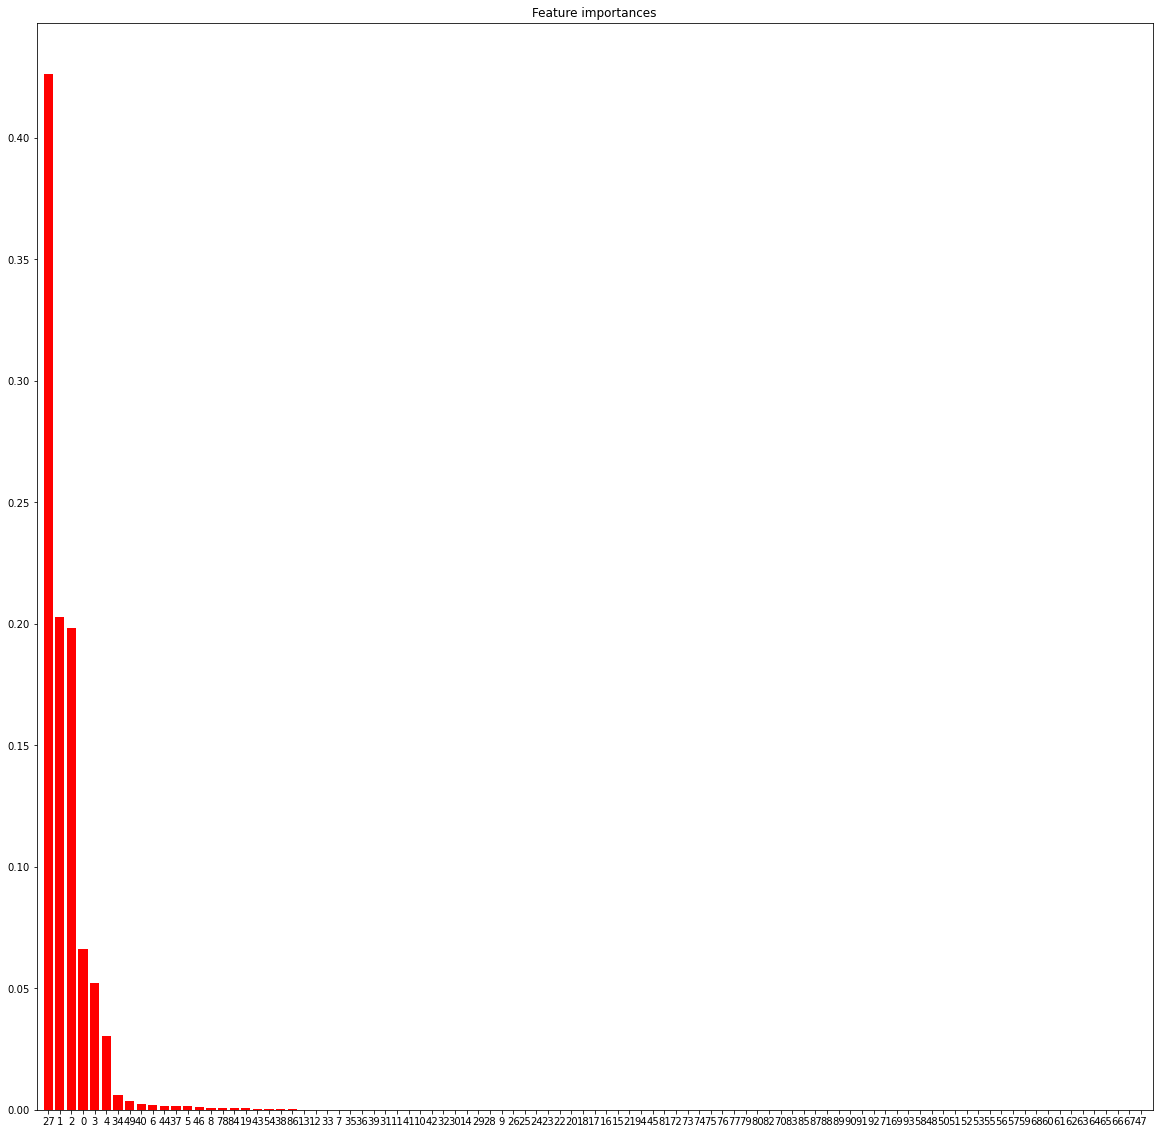

In [ ]:
feature_names = list(X_train.columns)

importances = clf.feature_importances_ ## most important line in this cell

indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(f'{f+1} feature {feature_names[indices[f]]} {importances[indices[f]]}')


plt.figure(figsize=(20, 20))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# What the most important hyper parameters in DT ?

- ``criterion`` : optional (default=”gini”) or Choose attribute selection measure: This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.


- ``splitter`` : string, optional (default=”best”) or Split Strategy: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.


- ``max_depth`` : int or None, optional (default=None) or Maximum Depth of a Tree: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting 


- ``min_samples_split`` : int or float, default=2 . The minimum number of samples required to split an internal node


- ``class_weight``: dict, list of dict or “balanced”, default=None

## Hyperparameter tuning

In [ ]:
clf = tree.DecisionTreeClassifier( criterion='entropy', max_depth = max_depth)

print("Start fitting the data")

hp = {"criterion":['gini','entropy'], 'max_depth':np.arange(3,9)}
for cv in tqdm(range(3,6)):
    grid = GridSearchCV(clf, param_grid  = hp  , cv = cv)
    grid.fit(X_train,y_train)
    print(f"score for {cv} fold CV is : {grid.score(X_test,y_test)}")
    print(f"Best result {grid.best_params_}")

Start fitting the data


score for 3 fold CV is : 0.8536383225592574
Best result {'criterion': 'gini', 'max_depth': 8}
score for 4 fold CV is : 0.8538040775733466
Best result {'criterion': 'gini', 'max_depth': 8}
score for 5 fold CV is : 0.8539698325874358
Best result {'criterion': 'gini', 'max_depth': 8}



# Avoiding Overfitting :

1. Acquire more training data


2. Remove irrelevant attributes


3. **Grow full tree, then post-prune** 


4. Ensemble learning. 


## Pruning

We can perform the pruning either before building the fully grown tree - pre-pruning - or after building it - post-pruning-

- We have already performed pre-pruning by specifiying the maximum depth in our implementation, or by controlling the different hyperparameters in sklearn implementation such as the min_samples_split and max_leaf_nodes


- However, this approach is not preferred or shouldn't be used alone, because a seemingly worthless split early on in the tree might be followed by a very good split.


- Therefore, it should be combined with post-pruning, also known as cost-complexity pruning and as weakest link pruning.

We can perform post-purning to prune the fully grown tree in a *bottom-up manner*.

- The idea is basically about, starting at the leaves, each node is replaced with its most popular class.


- If the prediction accuracy is not affected then the change is kept. 



We can also explain it as follows :

- Rather than considering every possible subtree, we consider a sequence of trees indexed by a nonnegative tuning parameter α.


- For each value of α there corresponds a subtree $$T ⊂ T_0$$ such that Cost $$T = Error(T) + α |T|$$ is small as possible


- $$|T|$$ indicates the number of terminal nodes of the tree T


- The tuning parameter α controls a trade-off between the subtree’s complexity and its fit to the training data. When α = 0, then the subtree T will simply equal $$T_0$$


- as we increase α from zero, branches get pruned from the tree

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

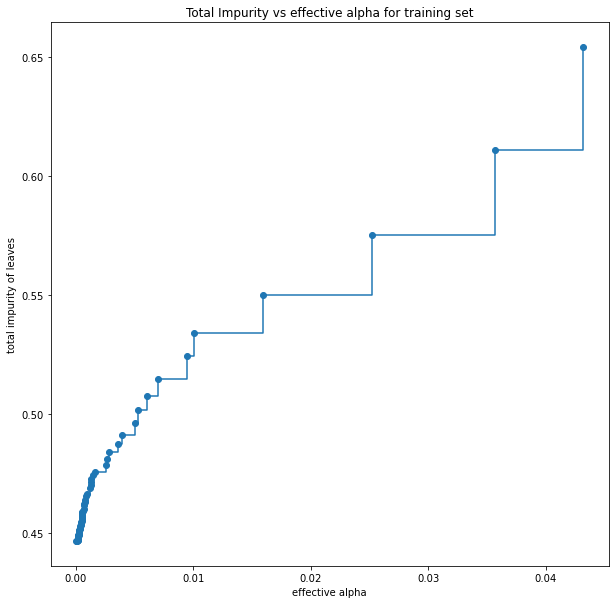

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2 , random_state = 10)

X_train = pd.get_dummies(X_train,drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)
clf = tree.DecisionTreeClassifier( criterion='entropy', max_depth = max_depth)
path = clf.cost_complexity_pruning_path(X_train, y_train) ## Pruning !

ccp_alphas, impurities = path.ccp_alphas, path.impurities ## Alpha we have been talking about
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Next, we train a decision tree using the effective ``alphas``. The last value in ``ccp_alphas`` is the alpha value that prunes the whole tree, leaving the tree, ``clfs[-1]``, with one node.

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.15397075459323895


Now, we remove the last element in ``clfs`` and ``ccp_alphas``, because it is the trivial tree with only one node.


Here we show that the number of nodes and tree depth decreases as alpha increases.

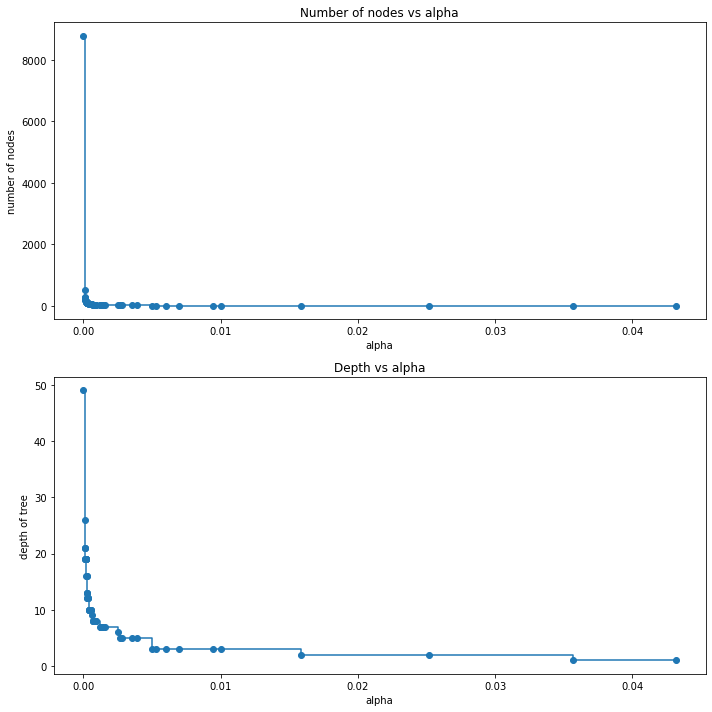

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1,figsize=(10,10))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

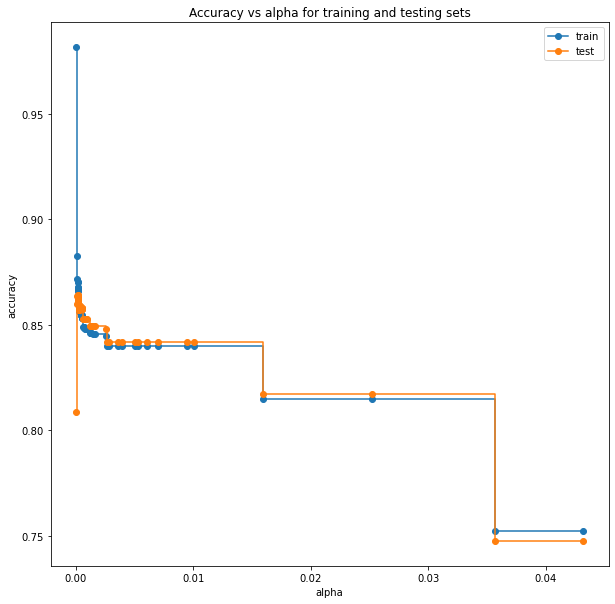

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

* As we can see, When ``ccp_alpha`` is set to ``zero`` and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a ``97.5%`` training accuracy and ``80%`` testing accuracy.


* As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better.Setting ``ccp_alpha=8.70266265e-05`` maximizes the testing accuracy

# Extra : Gain Ratio
Information gain is biased for the attribute with many outcomes. It means it prefers the attribute with a large number of distinct values. For instance, consider an attribute with a unique identifier such as customer_ID has zero info(D) because of pure partition. This maximizes the information gain and creates useless partitioning.

C4.5, an improvement of ID3, uses an extension to information gain known as the gain ratio. Gain ratio handles the issue of bias by normalizing the information gain using Split Info

# Decision Tree Pros and Cons


| Pros | Cons
| --- | --- 
|Easy to interpret and visualize.| Sensitive to noisy data. It can overfit noisy data.
|Has no assumptions about distribution because of the non-parametric nature of the algorithm.|The small variation(or variance) in data can result in the different decision tree. This can be reduced by bagging and boosting algorithms.
|Can easily capture Non-linear patterns.|Biased with imbalance dataset, so it is recommended that balance out the dataset before creating the decision tree.
|It requires fewer data preprocessing from the user, for example, there is no need to normalize columns.|Greedy algorithms don’t yield the global optimum tree structure.
|It can be used for feature engineering such as predicting missing values, suitable for variable selection.| As the branching goes deeper, you get exponentially less data.
|It has no problem whether the inputs and outputs are binary, categorical or continuous

# Tasks [ 10 points ]

## Task 1 : Work with the COMPLETE [dataset](https://archive.ics.uci.edu/ml/datasets/adult)

- **[ 2 points ] :** Load the dataset and perform the proper data preprocessing/ cleaning. Justify all your steps. Elaborate and descripe as much as possible. Don't worry, I will read everything.


- **[ 2 point  ] :** Run our implementation on the complete dataset. Compare the accuracy you get with the one we got before. Explain why the results are either better or worse.


- **[ 1 point  ] :** Perform hyper-parameter tuning using gridsearch. 


- **[ 1 point  ] :** Visualize the tree by using the sklearn functions. Discuss the first two features and attributes that the tree were split on. Do you they make sense for you? Why?


- **[ 2 point  ] :** Plot the feature importance, and choose the most important 5 of them and run our algorithm only on them. Compare the accuracy you get with the accuracy you got on the full dataset. 


## Task 2 : Work with another classification dataset from your choice
- **[ 2 points ] :** Do the same steps we did in Task 1 but with a classification dataset you choose. No minimum accuracy required.




## Bonus Task : Work with another *regression* dataset from your choice 
- **[ 3 points ] :** Use sklearn DecisionTree regressor on a regression dataset from your choice. It needs to be a one that we did not use in the course so far. You need to perform all the necessary preprocessing/visualization and justify it.